In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from PIL import Image, UnidentifiedImageError

# Ruta de la carpeta de imagenes y del CSV
image_dir = '/content/drive/My Drive/Proyecto-DataSets/imagenes-dataset-2'
csv_file = '/content/drive/My Drive/Proyecto-DataSets/dataset-3.csv'

df = pd.read_csv(csv_file)

# Dado el dataset, si hay varios ingredientes que machee con una coma entre cada ingrediente
df['label'] = df['label'].apply(lambda x: x.split(','))

# Función para convertir imágenes de paleta (modo 'P') a RGBA
# Ya que se necesita tener las imagenes en RGBA
def convertir_a_rgba(image_path):
    try:
        # Verifica si la imagen es .png antes de intentar convertir
        if image_path.lower().endswith('.png'):
            with Image.open(image_path) as img:
                if img.mode == 'P':  # Solo convertir si está en modo Paleta (P)
                    img = img.convert('RGBA')
                    img.save(image_path)  # Sobreescribe la imagen en RGBA
                    print(f"Convertida: {image_path} a RGBA")
                else:
                    print(f"La imagen {image_path} ya está en modo {img.mode}")
        else:
            print(f"{image_path} no es un archivo PNG. No se requiere conversión.")
    except UnidentifiedImageError:
        print(f"Error al abrir la imagen {image_path}")
    except Exception as e:
        print(f"Ocurrió un error al procesar {image_path}: {e}")
        return False

valid_extensions = ['.jpg', '.jpeg', '.png']

# Listas para almacenar imágenes y etiquetas válidas
valid_images = []
valid_labels = []

# Recorre cada fila del DataFrame
for i, row in df.iterrows():
    image_path = os.path.join(image_dir, row['image'])

    # Verificar que la imagen exista, no esté vacía y tenga una extensión válida
    if os.path.exists(image_path) and os.path.getsize(image_path) > 0 and any(image_path.lower().endswith(ext) for ext in valid_extensions):

        # Convierte la imagen a RGBA si está en formato de paleta
        convertir_a_rgba(image_path)

        # Si la imagen es válida, agregarla a la lista
        valid_images.append(row['image'])
        valid_labels.append(row['label'])
    else:
        print(f"La imagen {row['image']} no existe o está vacía.")

print(f"Número total de imágenes en el CSV: {len(df)}")
print(f"Número de imágenes válidas: {len(valid_images)}")

# Crea un nuevo DataFrame solo con las imágenes y etiquetas válidas
df_valid = pd.DataFrame({
    'image': valid_images,
    'label': valid_labels
})

# Aplicar One-Hot Encoding a las etiquetas
mlb = MultiLabelBinarizer()
df_valid['one_hot_label'] = mlb.fit_transform(df_valid['label']).tolist()

# Crear el dataset final con las imágenes y las etiquetas one-hot
one_hot_labels = pd.DataFrame(df_valid['one_hot_label'].to_list(), columns=mlb.classes_)
df_final = pd.concat([df_valid['image'], one_hot_labels], axis=1)

# Guardar el dataset limpio con one-hot encoding
clean_csv_path = '/content/drive/My Drive/Proyecto-DataSets/dataset-3_clean_one_hot.csv'
df_final.to_csv(clean_csv_path, index=False)

# Muestra las clases que se han codificado
print("Clases: ", mlb.classes_)

/content/drive/My Drive/Proyecto-DataSets/imagenes-dataset-2/imagen_120.jpg no es un archivo PNG. No se requiere conversión.
/content/drive/My Drive/Proyecto-DataSets/imagenes-dataset-2/imagen_121.jpg no es un archivo PNG. No se requiere conversión.
/content/drive/My Drive/Proyecto-DataSets/imagenes-dataset-2/imagen_122.jpg no es un archivo PNG. No se requiere conversión.
/content/drive/My Drive/Proyecto-DataSets/imagenes-dataset-2/imagen_123.jpg no es un archivo PNG. No se requiere conversión.
/content/drive/My Drive/Proyecto-DataSets/imagenes-dataset-2/imagen_124.jpg no es un archivo PNG. No se requiere conversión.
/content/drive/My Drive/Proyecto-DataSets/imagenes-dataset-2/imagen_125.jpg no es un archivo PNG. No se requiere conversión.
/content/drive/My Drive/Proyecto-DataSets/imagenes-dataset-2/imagen_126.jpg no es un archivo PNG. No se requiere conversión.
/content/drive/My Drive/Proyecto-DataSets/imagenes-dataset-2/imagen_127.jpg no es un archivo PNG. No se requiere conversión.


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Se normaliza de 0 a 1 para un entrenamiento mejor y luego se aplica 20% de validacion.
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)


# Dataset de entrenamiento
train_dataset = datagen.flow_from_dataframe(
    dataframe=df_final,
    directory=image_dir,
    x_col="image",
    y_col=mlb.classes_.tolist(), # Cada imagen esta asociada con las etiquetas correctas
    target_size=(224, 224), # Tamaño de la imagen, que luego espera MobileNet
    batch_size=32, # Tamaño del batch que entrena
    class_mode="raw",
    subset="training", # Subconjunto para entrenamiento
    shuffle=True
)

# Dataset de validación
validation_dataset = datagen.flow_from_dataframe(
    dataframe=df_final,
    directory=image_dir,
    x_col="image",
    y_col=mlb.classes_.tolist(),
    target_size=(224, 224),
    batch_size=32, # Tamaño del batch que valida, que luego espera MobileNet
    class_mode="raw",
    subset="validation"  # subconjunto para validación
)


Found 224 validated image filenames.
Found 56 validated image filenames.


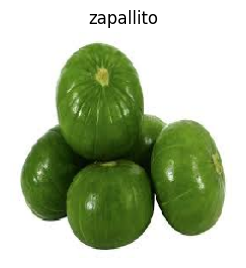

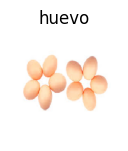

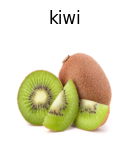

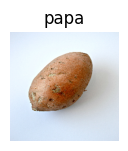

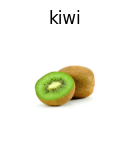

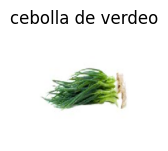

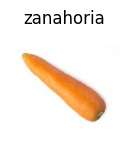

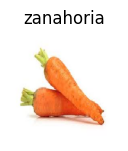

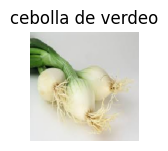

In [4]:
import matplotlib.pyplot as plt

class_indices = {i: label for i, label in enumerate(mlb.classes_)}  # Crear diccionario de índices de clase , para ver las etiquetas con la imagen bien.

image, label = next(train_dataset)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[i])
    plt.title(', '.join([class_indices[j] for j in range(len(label[i])) if label[i][j] > 0]))
    plt.axis("off")
    plt.show()



In [6]:
import tensorflow as tf

# Data augmentation para que no generalize o sobreajuste al entrenarse
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomTranslation(0.2, 0.2)
])

# Modelo preentrenado MobileNet
base_model = tf.keras.applications.MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Congelamos las capas del modelo base para que solo MobileNet se use como extractor de caracteristicas y nada mas.
for layer in base_model.layers:
    layer.trainable = False

# Construcción del modelo
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)), # Capa de entrada que espera el MobileNet , 224 x 224 y RGB es decir 3.
    data_augmentation,  # Aumentación de datos
    base_model,  # Modelo base
    # En este paso se empiezan a entrenar el dataset nuestro, capas personalizadas para nuestro problema particular.
    tf.keras.layers.GlobalAveragePooling2D(), #
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(mlb.classes_), activation='sigmoid')  # Capa de salida con depende cuantas clases se entrene.
])

# Compilamos el modelo con un optimizador Adam.
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Bajamos la tasa de aprendizaje para un ajuste más fino.
    loss='binary_crossentropy',  # Binary_crossentropy ya que es para problema multilabel como este.
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
    ]
)

# Resumen del modelo para ver las capas, como entran y como salen.
model.summary()

# Callbacks

# EarlyStopping con monitoreo de 'val_loss' y paciencia ajustada
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=35,
    restore_best_weights=True
)

# ReduceLROnPlateau para ajustar la tasa de aprendizaje cuando la pérdida no mejora
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,  # Reduce la tasa de aprendizaje en un factor de 0.2
    patience=12,  # Reducción de la tasa de aprendizaje si la pérdida no mejora durante 5 épocas
    min_lr=0.00001  # Tasa de aprendizaje mínima
)

# Entrenamiento
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=400,  # Aumentamos el número de épocas ya que estamos utilizando early stopping
    callbacks=[early_stopping, reduce_lr]
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 14)                  │           1,806 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,082,958 (11.76 MB)

 Trainable params: 823,438 (3.14 MB)

 Non-trainable params: 2,259,520 (8.62 MB)

Epoch 1/400


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 199s 8s/step - accuracy: 0.0790 - auc: 0.5384 - loss: 0.9723 - precision: 0.0792 - recall: 0.5036 - val_accuracy: 0.1607 - val_auc: 0.4980 - val_loss: 0.6454 - val_precision: 0.0814 - val_recall: 0.4286 - learning_rate: 1.0000e-04
Epoch 2/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 312ms/step - accuracy: 0.1153 - auc: 0.5739 - loss: 0.9414 - precision: 0.0834 - recall: 0.5168 - val_accuracy: 0.1964 - val_auc: 0.5192 - val_loss: 0.6359 - val_precision: 0.0922 - val_recall: 0.4643 - learning_rate: 1.0000e-04
Epoch 3/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 302ms/step - accuracy: 0.1025 - auc: 0.4962 - loss: 0.9352 - precision: 0.0716 - recall: 0.4218 - val_accuracy: 0.2143 - val_auc: 0.5418 - val_loss: 0.6254 - val_precision: 0.1019 - val_recall: 0.4821 - learning_rate: 1.0000e-04
Epoch 4/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 306ms/step - accuracy: 0.0779 - auc: 0.5632 - loss: 0.8774 - precision: 0.0826 - recall: 0.4709 - val_accuracy: 0.2321 - val_auc: 0.5607 - val_loss: 0.6153 - val_prec

In [7]:
loss, accuracy, auc, precision, recall = model.evaluate(train_dataset)
print(f"loss en entrenamiento: {loss}")
print(f"accuracy en entrenamiento: {accuracy}")
print(f"auc en entrenamiento: {auc}")
print(f"precision en entrenamiento: {precision}")
print(f"recall en entrenamiento: {recall}")
val_loss, val_accuracy, val_auc, val_precision, val_recall = model.evaluate(validation_dataset)
print(f"perdida en validación: {val_loss}")
print(f"accuracy en validación: {val_accuracy}")
print(f"auc en validación: {val_auc}")
print(f"precisión en validación: {val_precision}")
print(f"recall en validación: {val_recall}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 427ms/step - accuracy: 0.9971 - auc: 0.9997 - loss: 0.0699 - precision: 0.9920 - recall: 0.9493
loss en entrenamiento: 0.07200716435909271
accuracy en entrenamiento: 0.9910714030265808
auc en entrenamiento: 0.9997033476829529
precision en entrenamiento: 0.9861111044883728
recall en entrenamiento: 0.9508928656578064
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 345ms/step - accuracy: 0.0223 - auc: 0.4837 - loss: 0.3343 - precision: 0.0000e+00 - recall: 0.0000e+00
perdida en validación: 0.33392995595932007
accuracy en validación: 0.01785714365541935
auc en validación: 0.4907771348953247
precisión en validación: 0.0
recall en validación: 0.0


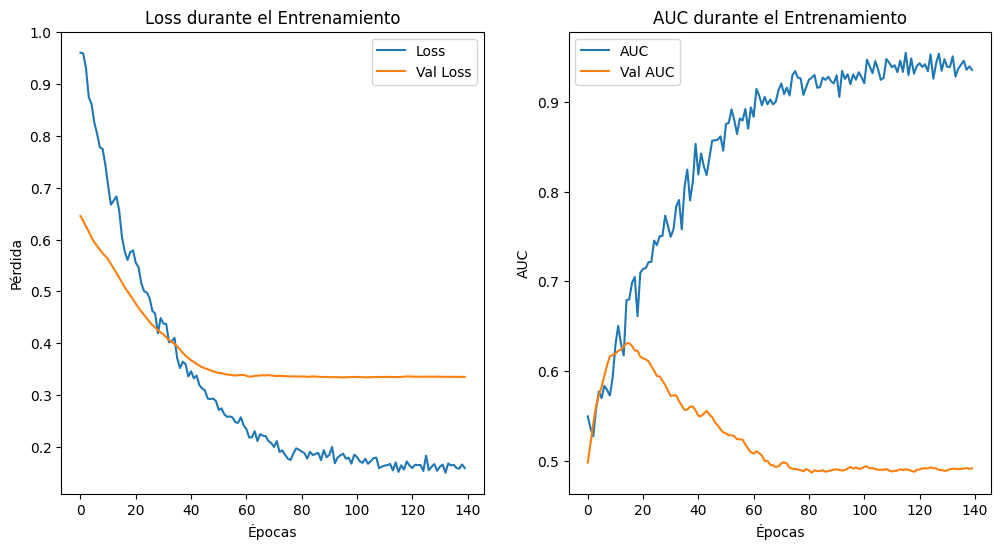

In [8]:
# Graficar loss y val_loss
plt.figure(figsize=(12, 6))

# Pérdida del entrenamiento
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# AUC del entrenamiento
plt.subplot(1, 2, 2)
plt.plot(history.history['auc'], label='AUC')
plt.plot(history.history['val_auc'], label='Val AUC')
plt.title('AUC durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('AUC')
plt.legend()

plt.show()


In [ ]:
model_save_path = '/content/drive/My Drive/Proyecto-DataSets/modeloEntrenado-3.keras'
model.save(model_save_path)